# Toy example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import ndcg_score
from scipy.stats import kendalltau

acc_mean = 10
top = 100

# Generate data points within the range 0-1 by filtering
data = pd.DataFrame({'val_acc': np.random.exponential(acc_mean, top**2)})
data = data.loc[(data['val_acc']<100) & (data['val_acc']>0)]
data['random_rank'] = np.random.permutation(len(data)) + 1
data['perfect_rank'] = data['val_acc'].rank(ascending=True)
data['damaged_rank'] = data['perfect_rank']
top_indices = data['damaged_rank'].nlargest(top).index
data.loc[top_indices, 'damaged_rank'] = range(top, 0, -1)
data.loc[~data.index.isin(top_indices), 'damaged_rank'] += top 

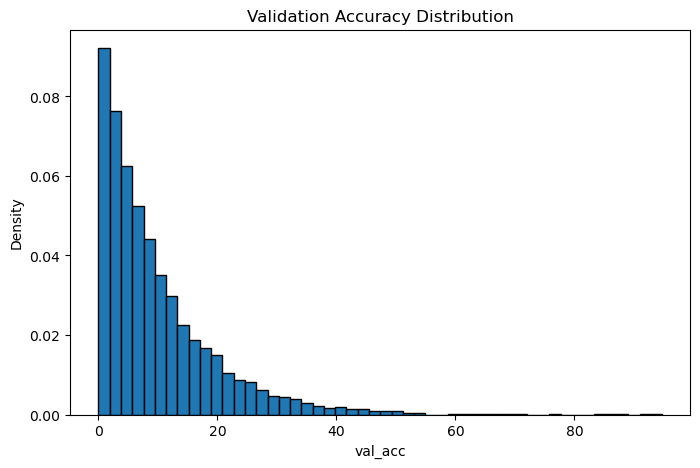

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(data['val_acc'], bins=50, edgecolor="black", density=True)
plt.title("Validation Accuracy Distribution")
plt.xlabel("val_acc")
plt.ylabel("Density")
plt.savefig('example_bad_kendall.eps', format='eps')
plt.show()
plt.close()

In [210]:
table = None
top1, top2, top3 = int(top/2), top, top*2
for rank in ['random_rank', 'perfect_rank', 'damaged_rank']:
    eval = {
        'ranking': [rank],
        'kendalltau': [kendalltau(data['val_acc'], data[rank]).statistic],
        'kendalltau_pvalue': [kendalltau(data['val_acc'], data[rank]).pvalue],
        f'ndcg_top{top1}': [ndcg_score(data['val_acc'].values.reshape(1, -1), data[rank].values.reshape(1, -1), k=top1)],
        f'ndcg_top{top2}': [ndcg_score(data['val_acc'].values.reshape(1, -1), data[rank].values.reshape(1, -1), k=top2)],
        f'ndcg_top{top3}': [ndcg_score(data['val_acc'].values.reshape(1, -1), data[rank].values.reshape(1, -1), k=top3)],
    }
    if table is None:
        table = pd.DataFrame(eval)
    else:
        table = pd.concat([table, pd.DataFrame(eval)], ignore_index=True)
table

,ranking,kendalltau,kendalltau_pvalue,ndcg_top50,ndcg_top100,ndcg_top200
0,random_rank,-0.003712,0.57775,0.145351,0.150057,0.183933
1,perfect_rank,1.000000,0.00000,1.000000,1.000000,1.000000
2,damaged_rank,0.960396,0.00000,0.670379,0.718864,0.770708


In [207]:
table = table.T

In [208]:
table = table.style.format(decimal=',', thousands='.', precision=2)

print(table.to_latex())

\begin{tabular}{llll}
 & 0 & 1 & 2 \\
ranking & random_rank & perfect_rank & damaged_rank \\
kendalltau & -0,00 & 1,00 & 0,96 \\
kendalltau_pvalue & 0,58 & 0,00 & 0,00 \\
ndcg_top50 & 0,15 & 1,00 & 0,67 \\
ndcg_top100 & 0,15 & 1,00 & 0,72 \\
ndcg_top200 & 0,18 & 1,00 & 0,77 \\
\end{tabular}



# VKDNW and trainable_params correlation

In [ ]:
import wandb
api_wandb = wandb.Api()
run = pd.DataFrame(api_wandb.run('nazderaze/VKDNW/ss2kwvpp').scan_history())
from scipy.stats import kendalltau

run['jacov'] = run['jacov'].astype(float)
run['trainability'] = run['trainability'].astype(float)
run['progressivity'] = run['progressivity'].astype(float)
run['expressivity'] = run['expressivity'].astype(float)
run.loc[run['jacov'].isnull(), 'jacov'] = run['jacov'].min()
run['te_nas'] = run['linear_region'].rank().apply(np.log)+run['ntk'].rank().apply(np.log)
run['az_nas'] = run['trainability'].rank().apply(np.log)+run['progressivity'].rank().apply(np.log)+run['expressivity'].rank().apply(np.log)
for pred in ['vkdnw_entropy', 'trainability', 'progressivity', 'expressivity', 'az_nas', 'jacov','gradsign', 'zico', 'zen', 'grad_norm', 'naswot', 'synflow', 'snip', 'grasp', 'te_nas']:

    run[pred] = run[pred].astype(float)
    data_to_plot = [run[pred][run['vkdnw_dim'] == cat] for cat in run['vkdnw_dim'].unique()]
    kt = kendalltau(run['vkdnw_dim'], run[pred]).statistic
    
    plt.figure(figsize=(8, 5))    
    plt.boxplot(data_to_plot, labels=run['vkdnw_dim'].unique(), showfliers=False)
    if pred == 'vkdnw_entropy':
        plt.title(f"vkdnw by #trainable_layers. (KT) correlation {kt:.2f}")
        plt.xlabel('#trainable_layers')
        plt.ylabel('vkdnw')
        plt.savefig(f'ImageNet16-120_unfiltered_vkdnw_num_params_boxplot.eps', format='eps')
    else:
        plt.title(f"vkdnw by #trainable_layers. (KT) correlation {kt:.2f}")
        plt.xlabel('#trainable_layers')
        plt.ylabel(pred)
    plt.show()

# Tables

In [6]:
import pandas as pd
import glob

In [15]:
table_struct = [
    ('kendall_mean', 'cifar10'),
    ('spearman_mean', 'cifar10'),
    ('ndcg_mean', 'cifar10'),
    ('kendall_mean', 'cifar100'),
    ('spearman_mean', 'cifar100'),
    ('ndcg_mean', 'cifar100'),
    ('kendall_mean', 'ImageNet16-120'),
    ('spearman_mean', 'ImageNet16-120'),
    ('ndcg_mean', 'ImageNet16-120'),
]

In [16]:
data_all = pd.concat([pd.read_csv(file) for file in glob.glob('NB201/*_log.csv')], ignore_index=True)
data_all = data_all.loc[data_all['archs_filtered_']=='filtered', :]
data_all = data_all.loc[(data_all['train_size_'].isnull()) | (data_all['train_size_']==1024), :]
data_all['train_size_'].unique()
table1 = data_all[['pred_name_', 'dataset_', 'kendall_mean', 'spearman_mean', 'ndcg_mean',]].pivot(index='pred_name_', columns=['dataset_'], values=['kendall_mean', 'spearman_mean', 'ndcg_mean',])

In [20]:
table1_formatted = table1.loc[['flops_rank', 'grad_norm_rank', 'grasp_rank', 'snip_rank', 'synflow_rank', 'naswot_rank', 'te_nas_rank', 'zen_rank', 'gradsign_rank', 'zico_rank', 'az_nas_rank', 'vkdnw_rank', 'vkdnw_comb_rank', 'pred_model_graf', 'pred_model_vkdnw', 'pred_model_vkdnw+zs', 'pred_model_vkdnw+zs+graf'], table_struct].applymap(lambda x: f"{x:.4f}")

table1_formatted.columns = ['_'.join(col) for col in table1_formatted.columns]
table1_formatted.index = table1_formatted.index.str.replace('_rank', '', regex=False)
table1_formatted.index = table1_formatted.index.str.replace('pred_', '', regex=False)
table1_formatted.to_latex()

'\\begin{tabular}{llllllllll}\n\\toprule\n & kendall_mean_cifar10 & spearman_mean_cifar10 & ndcg_mean_cifar10 & kendall_mean_cifar100 & spearman_mean_cifar100 & ndcg_mean_cifar100 & kendall_mean_ImageNet16-120 & spearman_mean_ImageNet16-120 & ndcg_mean_ImageNet16-120 \\\\\npred_name_ &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\nflops & 0.6227 & 0.7991 & 0.9955 & 0.5860 & 0.7634 & 0.9876 & 0.5453 & 0.7178 & 0.9655 \\\\\ngrad_norm & 0.3281 & 0.4383 & 0.9887 & 0.3405 & 0.4511 & 0.9723 & 0.3104 & 0.4176 & 0.9220 \\\\\ngrasp & 0.3519 & 0.5045 & 0.9876 & 0.3493 & 0.4983 & 0.9693 & 0.3591 & 0.5017 & 0.9204 \\\\\nsnip & 0.4308 & 0.5906 & 0.9893 & 0.4399 & 0.5965 & 0.9733 & 0.3893 & 0.5211 & 0.9231 \\\\\nsynflow & 0.5608 & 0.7579 & 0.9945 & 0.5533 & 0.7498 & 0.9869 & 0.5311 & 0.7185 & 0.9639 \\\\\nnaswot & 0.5708 & 0.7618 & 0.9951 & 0.6070 & 0.7990 & 0.9898 & 0.6052 & 0.7940 & 0.9730 \\\\\nte_nas & 0.5362 & 0.7215 & 0.9930 & 0.5372 & 0.7227 & 0.9834 & 0.5226 & 0.7091 & 0.9575 \\\\\nzen & 0.1020 

In [22]:
table1_formatted[['ndcg_mean_cifar10', 'ndcg_mean_cifar100', 'ndcg_mean_ImageNet16-120']]

,ndcg_mean_cifar10,ndcg_mean_cifar100,ndcg_mean_ImageNet16-120
pred_name_,,,
flops,0.9955,0.9876,0.9655
grad_norm,0.9887,0.9723,0.9220
grasp,0.9876,0.9693,0.9204
snip,0.9893,0.9733,0.9231
synflow,0.9945,0.9869,0.9639
naswot,0.9951,0.9898,0.9730
te_nas,0.9930,0.9834,0.9575
zen,0.9694,0.9196,0.8670
gradsign,0.9386,0.8489,0.7557
